In [1]:
import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler
from huggingface_hub import hf_hub_download

from photomaker import PhotoMakerStableDiffusionXLPipeline

2024-01-15 02:29:46.475640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 02:29:47.169654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize
    
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = 'SG161222/RealVisXL_V3.0'
photomaker_path = 'release_model/photomaker-v1.bin'
device = "cuda"
save_path = "./outputs"

In [3]:
# Load base model
pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
    base_model_path, 
    torch_dtype=torch.bfloat16, 
    use_safetensors=True, 
    variant="fp16",
#     local_files_only=True,
).to(device)

# Load PhotoMaker checkpoint
pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_path),
    subfolder="",
    weight_name=os.path.basename(photomaker_path),
    trigger_word="img"
)     

pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.fuse_lora()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading PhotoMaker components [1] id_encoder from [release_model]...
Loading PhotoMaker components [2] lora_weights from [release_model]


Input ID images:


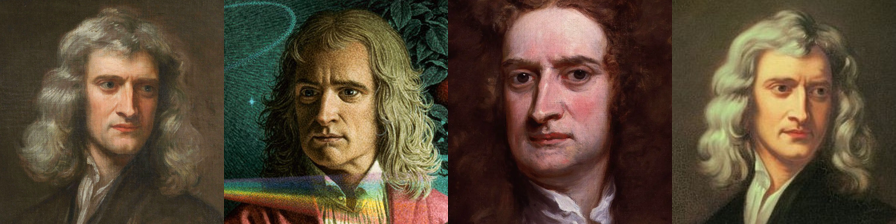

In [4]:
# define and show the input ID images
input_folder_name = './examples/newton_man'
image_basename_list = os.listdir(input_folder_name)
image_path_list = sorted([os.path.join(input_folder_name, basename) for basename in image_basename_list])

input_id_images = []
for image_path in image_path_list:
    input_id_images.append(load_image(image_path))
    
input_grid = image_grid(input_id_images, 1, 4, size_after_resize=224)
print("Input ID images:")
input_grid

In [5]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "sci-fi, closeup portrait photo of a man img wearing the sunglasses in Iron man suit, face, slim body, high quality, film grain"
negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30
    
images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    num_images_per_prompt=4,
    num_inference_steps=num_steps,
    start_merge_step=start_merge_step,
    generator=generator,
).images

torch.Size([4, 2048]) torch.Size([4, 2048])


  0%|          | 0/50 [00:00<?, ?it/s]

Results:


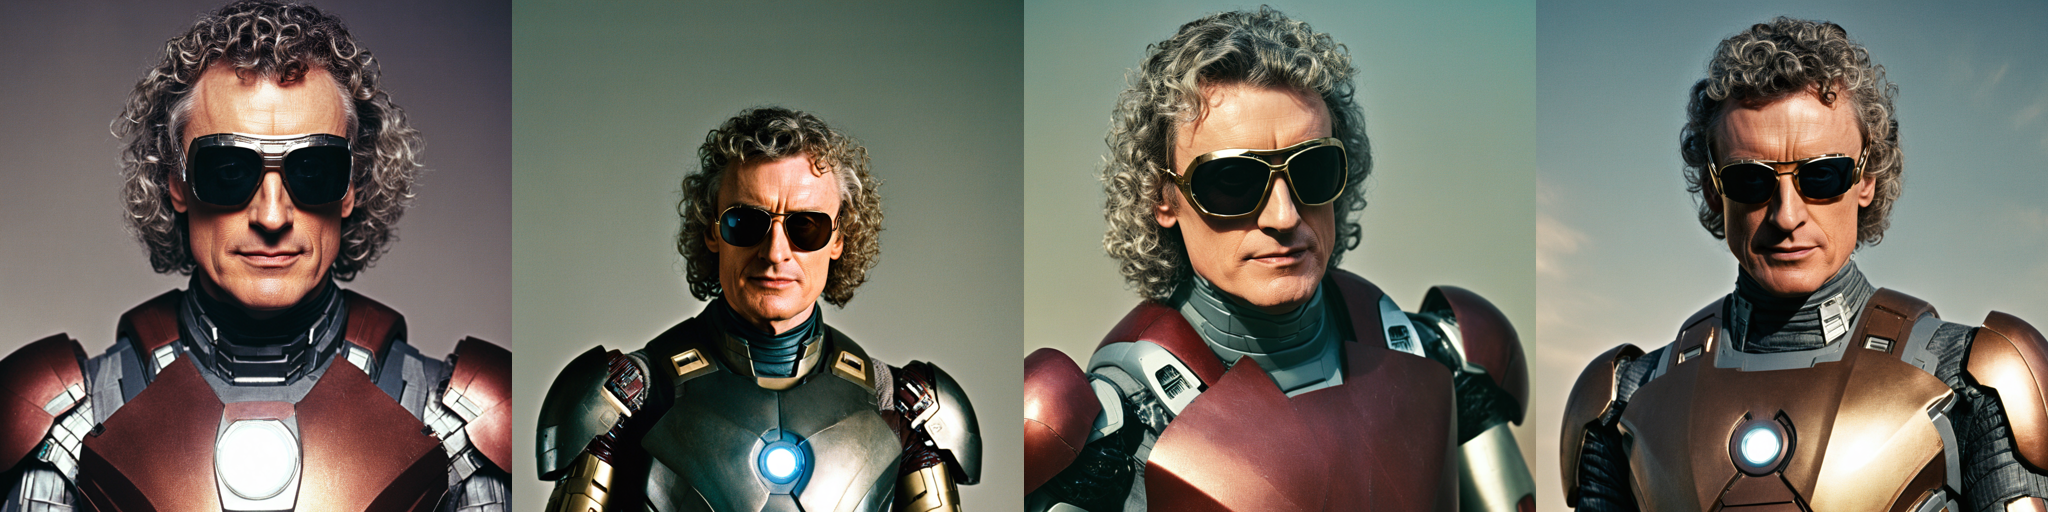

In [6]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 4, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_{idx:02d}.png"))
    
print("Results:")
grid